In [2]:
from gd_env import GeometryEnv
from model import Agent
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import shap
import matplotlib.pyplot as plt

# Explicador SHAP para el modelo DQN
def create_shap_explainer(agent, env, n_samples=200):
    """Crea un explicador SHAP basado en muestras del entorno."""
    def predict_q(states):
        states_t = torch.FloatTensor(states)
        with torch.no_grad():
            return agent.model(states_t).numpy()
    background = np.array([env.get_state() for _ in range(n_samples)])
    explainer = shap.KernelExplainer(predict_q, background)
    return explainer

# Visualizar la explicación SHAP para un estado concreto
def explain_state(agent, explainer, state):
    state = np.array(state).reshape(1, -1)
    shap_values = explainer.shap_values(state)
    shap.summary_plot(
        shap_values, 
        state, 
        feature_names=[
            "dist", "vy", "on_ground", "tipo_idx", "height_ratio",
            "time_to_obstacle", "landing_y_diff", "dist2", "tipo2_idx"
        ]
    )

# Visualización de sensibilidad local (gradientes)
def gradient_importance(agent, state):
    """Muestra qué variables influyen más en la acción elegida."""
    state_t = torch.FloatTensor(state).unsqueeze(0)
    state_t.requires_grad = True
    q_values = agent.model(state_t)
    best_action = torch.argmax(q_values).item()
    q_values[0, best_action].backward()

    importance = state_t.grad.abs().detach().numpy()[0]
    plt.bar(range(len(importance)), importance)
    plt.xticks(range(len(importance)), [
        "dist", "vy", "on_ground", "tipo_idx", "height_ratio",
        "time_to_obstacle", "landing_y_diff", "dist2", "tipo2_idx"
    ], rotation=45)
    plt.ylabel("Influencia (gradiente absoluto)")
    plt.title(f"Importancia de variables para acción {best_action}")
    plt.show()


c:\Users\Gerax\OneDrive\Desktop\UVGG\4-2\Deep\deep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

# creamos el entorno y el agente

env = GeometryEnv()
state_size = len(env.get_state())
action_size = 2  # 0: no saltar, 1: saltar

agent = Agent(state_size, action_size)

print("Creando explicador SHAP (esto puede tardar unos segundos)...")
explainer = create_shap_explainer(agent, env)

episodes = 200
batch_size = 64

explained_states = []   # estados que queremos analizar
shap_records = []       # valores SHAP calculados

# Almacenar métricas
rewards_history = []
epsilon_history = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    for t in range(1000):  # pasos por episodio
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        agent.replay(batch_size)
        if done:
            agent.update_target_model()
            break

    rewards_history.append(total_reward)
    epsilon_history.append(agent.epsilon)

    if (e + 1) % 50 == 0:  # cada 50 episodios, registramos un estado para análisis
        print(f"\n🧩 Guardando explicación para episodio {e + 1}...")
        sample_state = env.get_state().reshape(1, -1)
        shap_values = explainer.shap_values(sample_state)
        explained_states.append(sample_state)
        shap_records.append(shap_values)
    
    print("Ep", e + 1, "/", episodes, 
      "| Recompensa total:", round(total_reward, 2), 
      "| Epsilon:", round(agent.epsilon, 3))

# Guardar modelo
torch.save(agent.model.state_dict(), "geometry_dqn.pth")


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Creando explicador SHAP (esto puede tardar unos segundos)...
Ep 1 / 200 | Recompensa total: -5.0 | Epsilon: 0.86
Ep 2 / 200 | Recompensa total: -2.0 | Epsilon: 0.347
Ep 3 / 200 | Recompensa total: 2.0 | Epsilon: 0.065
Ep 4 / 200 | Recompensa total: 2.0 | Epsilon: 0.05
Ep 5 / 200 | Recompensa total: 1.0 | Epsilon: 0.05
Ep 6 / 200 | Recompensa total: -1.0 | Epsilon: 0.05
Ep 7 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 8 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 9 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 10 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 11 / 200 | Recompensa total: 12.0 | Epsilon: 0.05
Ep 12 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 13 / 200 | Recompensa total: 5.0 | Epsilon: 0.05
Ep 14 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 15 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 16 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 17 / 200 | Recompensa total: 2.0 | Epsilon: 0.05
Ep 18 / 200 | Recompensa total: -5.0 | Epsilon: 0.

100%|██████████| 1/1 [00:00<00:00, 38.08it/s]

Ep 50 / 200 | Recompensa total: -2.0 | Epsilon: 0.05


Ep 51 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 52 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 53 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 54 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 55 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 56 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 57 / 200 | Recompensa total: 1.0 | Epsilon: 0.05
Ep 58 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 59 / 200 | Recompensa total: 14.0 | Epsilon: 0.05
Ep 60 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 61 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 62 / 200 | Recompensa total: 5.0 | Epsilon: 0.05
Ep 63 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 64 / 200 | Recompensa total: 2.0 | Epsilon: 0.05
Ep 65 / 200 | Recompensa total: 6.0 | Epsilon: 0.05
Ep 66 / 200 | Recompensa total: 13.0 | Epsilon: 0.05
Ep 67 / 200 | Recompensa total: 3.0 | Epsilon: 0.05
Ep 68 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 69 / 200 | Recompensa total: 8.0 | Epsilon: 0.05

100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

Ep 100 / 200 | Recompensa total: -2.0 | Epsilon: 0.05


Ep 101 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 102 / 200 | Recompensa total: 2.0 | Epsilon: 0.05
Ep 103 / 200 | Recompensa total: 13.0 | Epsilon: 0.05
Ep 104 / 200 | Recompensa total: -3.0 | Epsilon: 0.05
Ep 105 / 200 | Recompensa total: 4.0 | Epsilon: 0.05
Ep 106 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 107 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 108 / 200 | Recompensa total: 4.0 | Epsilon: 0.05
Ep 109 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 110 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 111 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 112 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 113 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 114 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 115 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 116 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 117 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 118 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 119 / 200 | Recompensa total

100%|██████████| 1/1 [00:00<00:00, 29.49it/s]

Ep 150 / 200 | Recompensa total: -1.0 | Epsilon: 0.05


Ep 151 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 152 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 153 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 154 / 200 | Recompensa total: 3.0 | Epsilon: 0.05
Ep 155 / 200 | Recompensa total: 12.0 | Epsilon: 0.05
Ep 156 / 200 | Recompensa total: 3.0 | Epsilon: 0.05
Ep 157 / 200 | Recompensa total: 32.0 | Epsilon: 0.05
Ep 158 / 200 | Recompensa total: 25.0 | Epsilon: 0.05
Ep 159 / 200 | Recompensa total: 18.0 | Epsilon: 0.05
Ep 160 / 200 | Recompensa total: -3.0 | Epsilon: 0.05
Ep 161 / 200 | Recompensa total: 66.0 | Epsilon: 0.05
Ep 162 / 200 | Recompensa total: 28.0 | Epsilon: 0.05
Ep 163 / 200 | Recompensa total: 4.0 | Epsilon: 0.05
Ep 164 / 200 | Recompensa total: 14.0 | Epsilon: 0.05
Ep 165 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 166 / 200 | Recompensa total: 34.0 | Epsilon: 0.05
Ep 167 / 200 | Recompensa total: 50.0 | Epsilon: 0.05
Ep 168 / 200 | Recompensa total: 52.0 | Epsilon: 0.05
Ep 169 / 200 | Recompensa total

100%|██████████| 1/1 [00:00<00:00, 46.95it/s]

Ep 200 / 200 | Recompensa total: 46.0 | Epsilon: 0.05


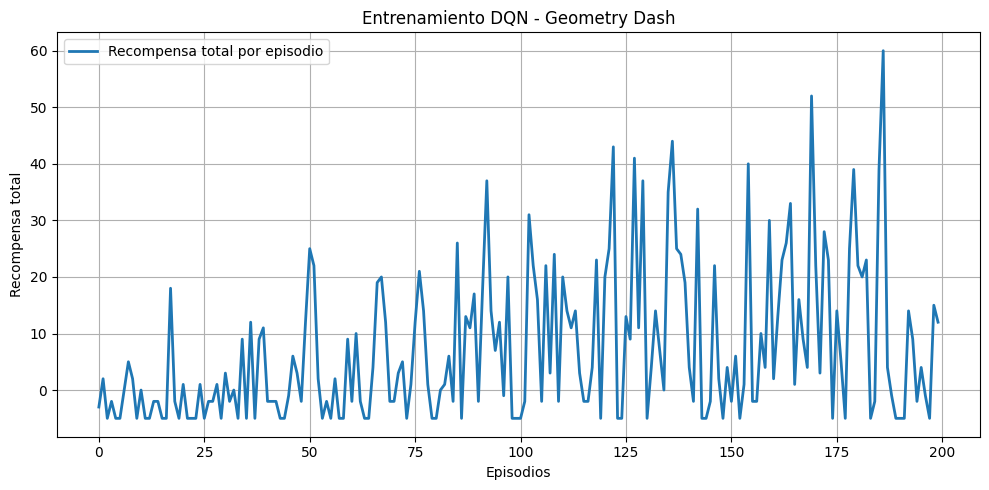

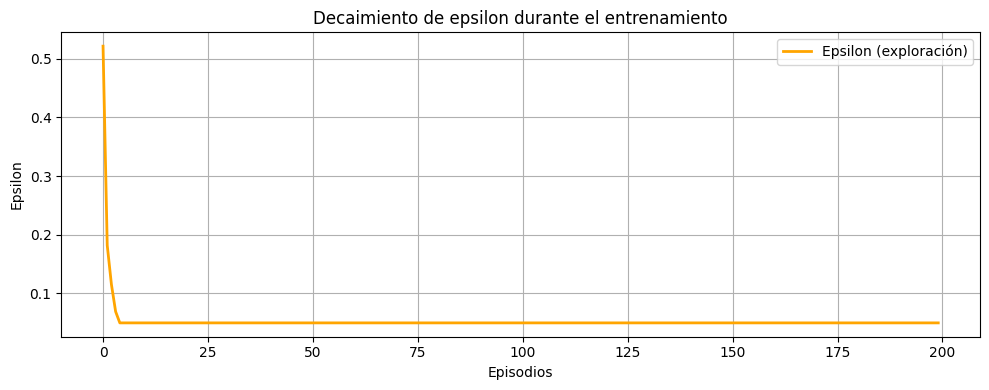

In [4]:
plt.figure(figsize=(10,5))
plt.plot(rewards_history, label="Recompensa total por episodio", linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Recompensa total")
plt.title("Entrenamiento DQN - Geometry Dash")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epsilon_history, color="orange", label="Epsilon (exploración)", linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Epsilon")
plt.title("Decaimiento de epsilon durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
print("\n🧾 Formas de las matrices antes de graficar:")
print("avg_state.shape =", avg_state.shape)
print("len(feature_names) =", 9)
for i, s in enumerate(shap_records):
    print(f"shap_records[{i}] type={type(s)} shape(s)=", np.array(s).shape)

print("avg_shap.shape =", avg_shap.shape)



🧾 Formas de las matrices antes de graficar:
avg_state.shape = (1, 9)
len(feature_names) = 9
shap_records[0] type=<class 'numpy.ndarray'> shape(s)= (1, 9, 2)
shap_records[1] type=<class 'numpy.ndarray'> shape(s)= (1, 9, 2)
shap_records[2] type=<class 'numpy.ndarray'> shape(s)= (1, 9, 2)
shap_records[3] type=<class 'numpy.ndarray'> shape(s)= (1, 9, 2)
avg_shap.shape = (1, 18)



Generando visualizaciones de explicabilidad...
avg_state.shape = (1, 9)
avg_shap_action1.shape = (1, 9)


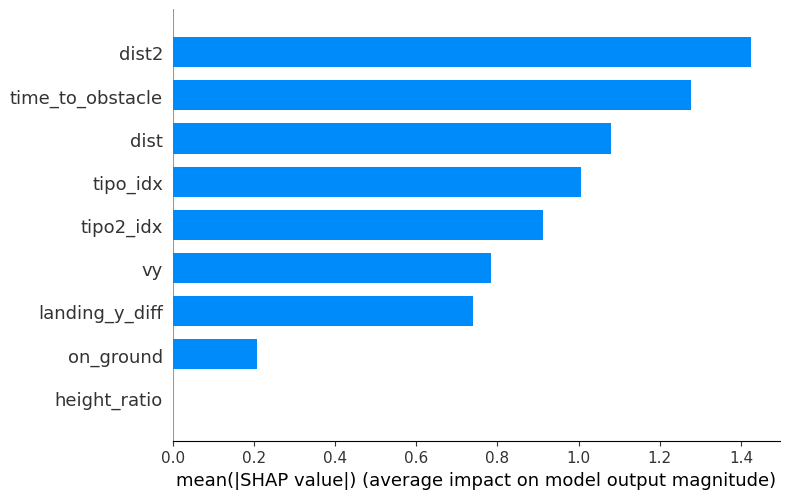


📊 Análisis de gradientes en último estado observado:


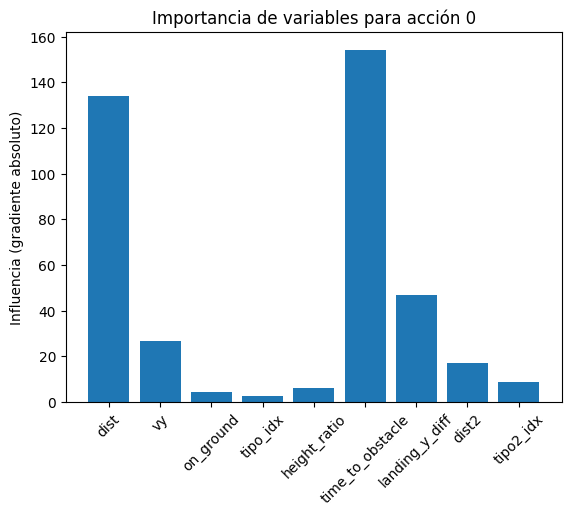

In [8]:
# ===========================================
# 🔍 Análisis final de IA explicable (ajustado al shape 1x9x2)
# ===========================================
print("\nGenerando visualizaciones de explicabilidad...")

if len(shap_records) > 0:
    avg_state = np.mean(np.vstack(explained_states), axis=0).reshape(1, -1)

    # Extraer y promediar explicaciones solo para la acción "saltar" (índice 1)
    all_shap_action1 = np.vstack([
        np.array(s)[:, :, 1]  # tomamos la 3ra dimensión (acción 1)
        for s in shap_records
    ])

    avg_shap_action1 = np.mean(all_shap_action1, axis=0).reshape(1, -1)

    print("avg_state.shape =", avg_state.shape)
    print("avg_shap_action1.shape =", avg_shap_action1.shape)

    shap.summary_plot(
        avg_shap_action1,
        avg_state,
        feature_names=[
            "dist", "vy", "on_ground", "tipo_idx", "height_ratio",
            "time_to_obstacle", "landing_y_diff", "dist2", "tipo2_idx"
        ],
        plot_type="bar",
        show=True
    )

    print("\n📊 Análisis de gradientes en último estado observado:")
    gradient_importance(agent, explained_states[-1][0])
else:
    print("No se registraron explicaciones suficientes durante el entrenamiento.")


In [14]:
import json

with open("explainable_records.json", "w") as f:
    json.dump(shap_records, f, indent=2)

print("💾 Registros explicativos guardados en 'explainable_records.json'")


💾 Registros explicativos guardados en 'explainable_records.json'


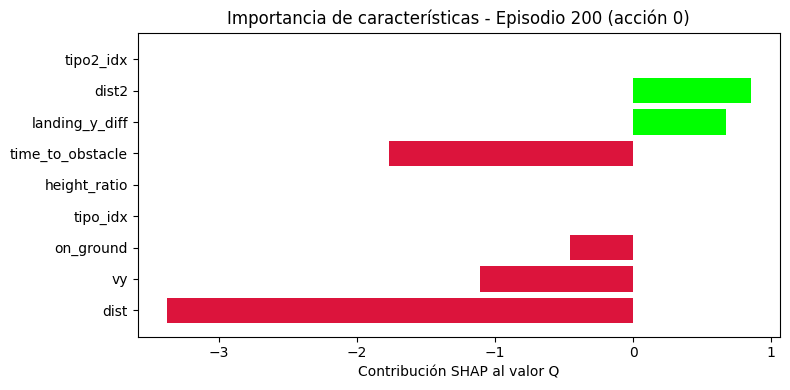

In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Cargar los registros guardados
with open("explainable_records.json") as f:
    records = json.load(f)

# Tomamos uno (ejemplo: episodio 200)
rec = records[-1]
features = [
    "dist", "vy", "on_ground", "tipo_idx", "height_ratio",
    "time_to_obstacle", "landing_y_diff", "dist2", "tipo2_idx"
]
shap_action1 = np.array(rec["shap_values"])[0, :, 1]  # acción 1 (saltar)
state_values = rec["state"]

# Mostrar qué “vio” el agente
plt.figure(figsize=(8, 4))
plt.barh(features, shap_action1, color=np.where(shap_action1 > 0, "lime", "crimson"))
plt.title(f"Importancia de características - Episodio {rec['episode']} (acción {rec['chosen_action']})")
plt.xlabel("Contribución SHAP al valor Q")
plt.tight_layout()
plt.show()


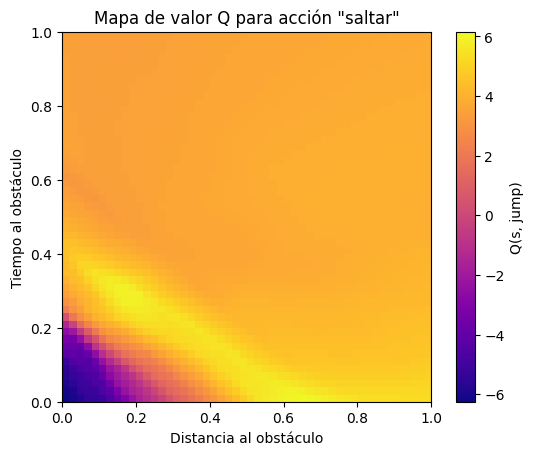

In [6]:
import numpy as np
import matplotlib.pyplot as plt

dist = np.linspace(0, 1, 50)
time_to_obstacle = np.linspace(0, 1, 50)
Q_jump = np.zeros((50, 50))

for i, d in enumerate(dist):
    for j, t in enumerate(time_to_obstacle):
        state = np.array([d, 0, 1, 0.5, 0.5, t, 0, 1, 0]).reshape(1, -1)
        with torch.no_grad():
            Q_jump[i, j] = agent.model(torch.FloatTensor(state))[0, 1].item()

plt.imshow(Q_jump, extent=[0,1,0,1], origin='lower', cmap='plasma')
plt.colorbar(label='Q(s, jump)')
plt.xlabel('Distancia al obstáculo')
plt.ylabel('Tiempo al obstáculo')
plt.title('Mapa de valor Q para acción "saltar"')
plt.show()


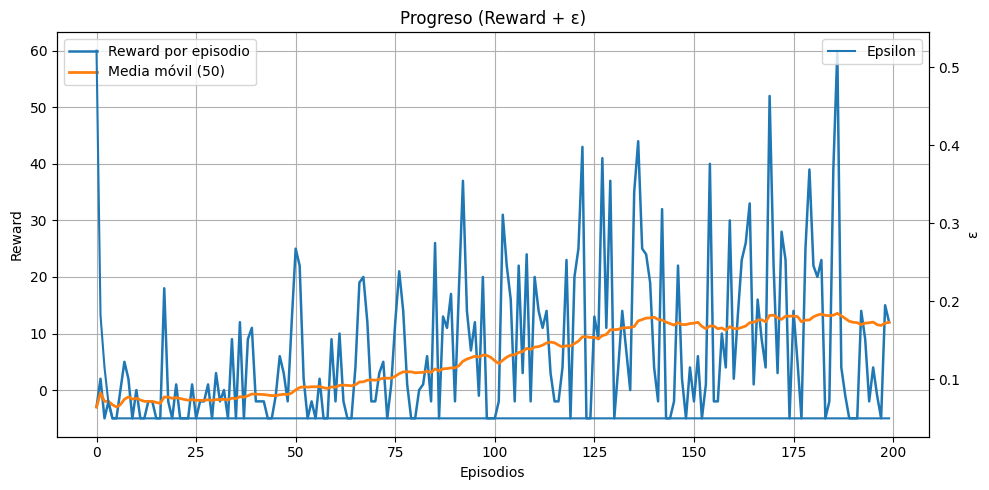

In [9]:
# Helpers y media móvil
from collections import deque

def moving_avg(seq, w=50):
    out, q, s = [], deque(), 0.0
    for v in seq:
        q.append(v); s += v
        if len(q) > w:
            s -= q.popleft()
        out.append(s/len(q))
    return out

# Gráfico extra: reward con media móvil + epsilon en eje secundario
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(rewards_history, label="Reward por episodio", linewidth=1.8)
ma = moving_avg(rewards_history, w=50)
if len(ma) == len(rewards_history):
    ax1.plot(ma, label="Media móvil (50)", linewidth=2)
ax1.set_xlabel("Episodios"); ax1.set_ylabel("Reward")
ax1.grid(True); ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(epsilon_history, label="Epsilon", linewidth=1.5)
ax2.set_ylabel("ε")
ax2.legend(loc="upper right")
plt.title("Progreso (Reward + ε)")
plt.tight_layout()
plt.show()


Random  -> reward(mean±sd): (-1.45, 4.455053310567675)  length: (171.5, 89.24488780877032)  obs: (3.55, 4.455053310567675)
Greedy  -> reward(mean±sd): (67.8, 84.69569056333386)  length: (7757.3, 18526.353813149526)  obs: (72.8, 84.69569056333386)


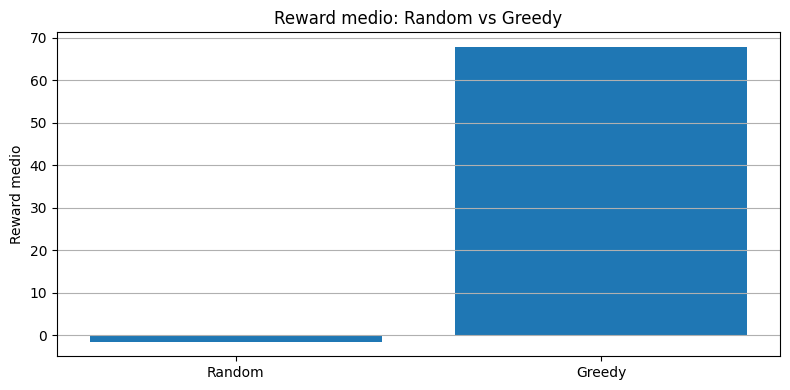

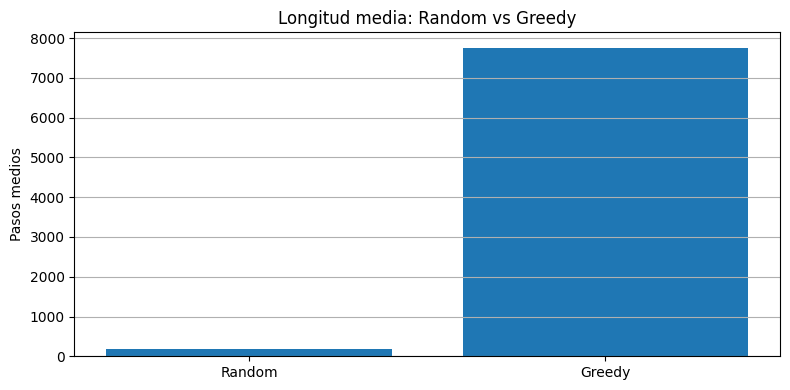

In [10]:
import torch
import numpy as np

def eval_policy(model, episodes=20, epsilon=None):
    """
    model: agent.model (torch.nn.Module)
    epsilon=None → greedy puro; epsilon=1.0 → random puro; epsilon=0.05 → casi greedy, etc.
    """
    device = next(model.parameters()).device if any(p.requires_grad for p in model.parameters()) else "cpu"
    stats = {"reward": [], "length": [], "obstacles": []}
    for _ in range(episodes):
        e = GeometryEnv()
        s = e.reset()
        done = False
        ep_rew, ep_len, ep_obs = 0.0, 0, 0.0
        while not done:
            if epsilon is None:  # greedy puro
                with torch.no_grad():
                    q = model(torch.tensor(s, dtype=torch.float32).unsqueeze(0))
                    a = int(q.argmax(dim=1).item())
            else:
                if np.random.rand() < epsilon:
                    a = np.random.randint(0, 2)
                else:
                    with torch.no_grad():
                        q = model(torch.tensor(s, dtype=torch.float32).unsqueeze(0))
                        a = int(q.argmax(dim=1).item())

            s2, r, done, info = e.step(a)
            ep_rew += r; ep_len += 1
            if r > 0:   # si tu shaping es +1 por obstáculo, esto cuenta obstáculos
                ep_obs += r
            s = s2

        stats["reward"].append(ep_rew)
        stats["length"].append(ep_len)
        stats["obstacles"].append(ep_obs)

    return {k: (float(np.mean(v)), float(np.std(v))) for k,v in stats.items()}

# Ejecutar comparativa
rand_stats = eval_policy(agent.model, episodes=20, epsilon=1.0)
greedy_stats = eval_policy(agent.model, episodes=20, epsilon=None)

print("Random  -> reward(mean±sd):", rand_stats["reward"], " length:", rand_stats["length"], " obs:", rand_stats["obstacles"])
print("Greedy  -> reward(mean±sd):", greedy_stats["reward"], " length:", greedy_stats["length"], " obs:", greedy_stats["obstacles"])

# Barras simples (mean)
labels = ["Random","Greedy"]
means_reward = [rand_stats["reward"][0], greedy_stats["reward"][0]]
means_length = [rand_stats["length"][0], greedy_stats["length"][0]]

plt.figure(figsize=(8,4))
plt.bar(labels, means_reward)
plt.title("Reward medio: Random vs Greedy")
plt.ylabel("Reward medio"); plt.grid(True, axis="y"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.bar(labels, means_length)
plt.title("Longitud media: Random vs Greedy")
plt.ylabel("Pasos medios"); plt.grid(True, axis="y"); plt.tight_layout(); plt.show()


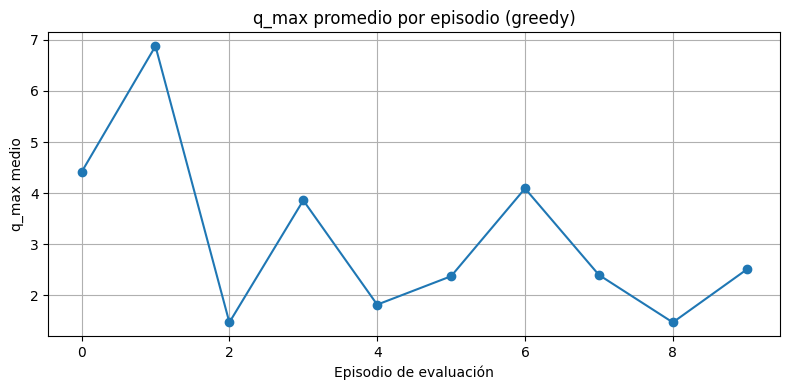

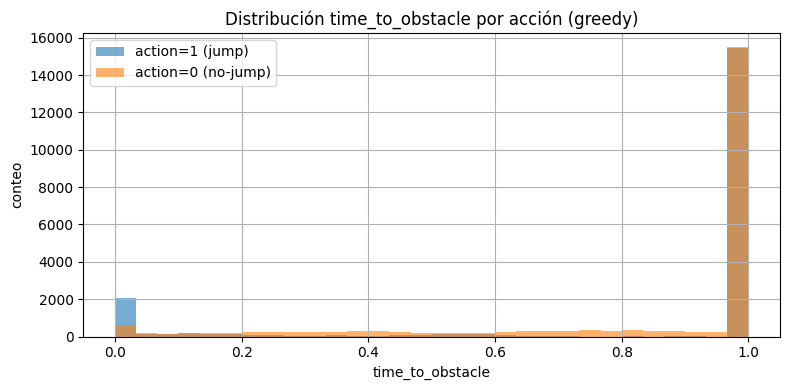

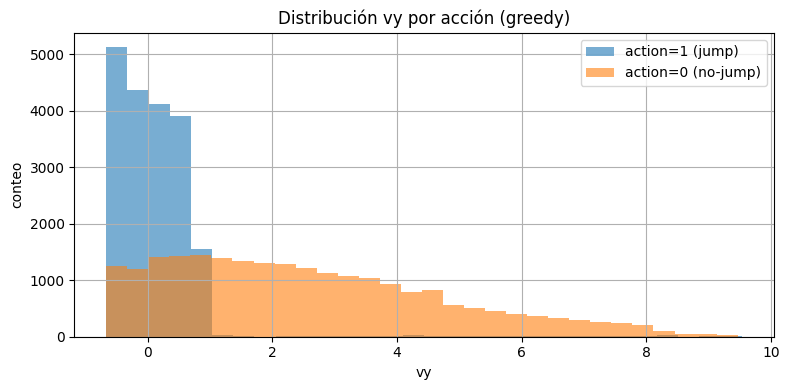

In [11]:
qmax_por_ep = []
tto_jump, tto_nojump = [], []
vy_jump, vy_nojump = [], []

EP_EVAL = 10
for _ in range(EP_EVAL):
    e = GeometryEnv()
    s = e.reset()
    done = False
    qmax_acc = []
    while not done:
        # Q(s,·), acción greedy
        with torch.no_grad():
            q = agent.model(torch.tensor(s, dtype=torch.float32).unsqueeze(0))
            qvals = q.squeeze(0).numpy()
            a = int(np.argmax(qvals))
            qmax_acc.append(float(np.max(qvals)))

        # features del estado (ajusta si tu orden difiere)
        dist, vy, on_ground, tipo_idx, height_ratio, tto, land_dy, dist2, tipo2 = s

        s2, r, done, info = e.step(a)

        if a == 1:
            tto_jump.append(float(tto))
            vy_jump.append(float(vy))
        else:
            tto_nojump.append(float(tto))
            vy_nojump.append(float(vy))

        s = s2

    qmax_por_ep.append(np.mean(qmax_acc) if qmax_acc else np.nan)

# Gráficos
plt.figure(figsize=(8,4))
plt.plot(qmax_por_ep, marker="o")
plt.title("q_max promedio por episodio (greedy)")
plt.xlabel("Episodio de evaluación"); plt.ylabel("q_max medio"); plt.grid(True); plt.tight_layout(); plt.show()

if len(tto_jump)>0 and len(tto_nojump)>0:
    plt.figure(figsize=(8,4))
    plt.hist(tto_jump, bins=30, alpha=0.6, label="action=1 (jump)")
    plt.hist(tto_nojump, bins=30, alpha=0.6, label="action=0 (no-jump)")
    plt.title("Distribución time_to_obstacle por acción (greedy)")
    plt.xlabel("time_to_obstacle"); plt.ylabel("conteo"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

if len(vy_jump)>0 and len(vy_nojump)>0:
    plt.figure(figsize=(8,4))
    plt.hist(vy_jump, bins=30, alpha=0.6, label="action=1 (jump)")
    plt.hist(vy_nojump, bins=30, alpha=0.6, label="action=0 (no-jump)")
    plt.title("Distribución vy por acción (greedy)")
    plt.xlabel("vy"); plt.ylabel("conteo"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd

# A nivel episodio (del entreno que ya hiciste)
df_epi = pd.DataFrame({
    "episode": np.arange(1, len(rewards_history)+1),
    "reward": rewards_history,
    "epsilon": epsilon_history
})
df_epi.to_csv("logs_episodios.csv", index=False)

# A nivel evaluación (random vs greedy)
df_eval = pd.DataFrame({
    "policy": ["random","greedy"],
    "reward_mean": [rand_stats["reward"][0], greedy_stats["reward"][0]],
    "reward_std":  [rand_stats["reward"][1], greedy_stats["reward"][1]],
    "length_mean": [rand_stats["length"][0], greedy_stats["length"][0]],
    "length_std":  [rand_stats["length"][1], greedy_stats["length"][1]]
})
df_eval.to_csv("eval_runs.csv", index=False)

print("CSV guardados: logs_episodios.csv, eval_runs.csv")
